In [203]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import glob

In [30]:
print(f"Images in train_v2: {len(os.listdir('Data/train_v2/'))}")
print(f"Images in test_v2:  {len(os.listdir('Data/test_v2/'))}")

Images in train_v2: 192556
Images in test_v2:  15606


In [31]:
print(glob.glob("Data/train_v2/*.jpg")[0])

Data/train_v2\00003e153.jpg


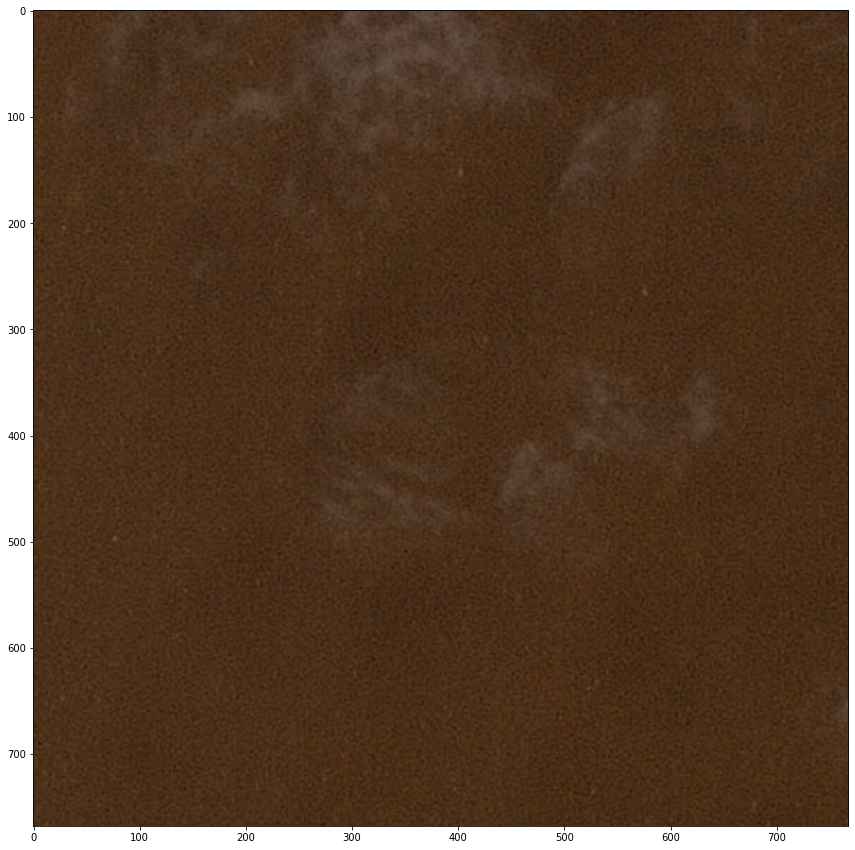

In [32]:
image = cv2.imread(glob.glob("Data/train_v2/*.jpg")[0])
plt.figure(figsize=(15, 15))
plt.imshow(image)

Так як OpenCV зчитує картинку по дефолту у форматі BGR, необхідно трансфоормувати картинку в RGB формат

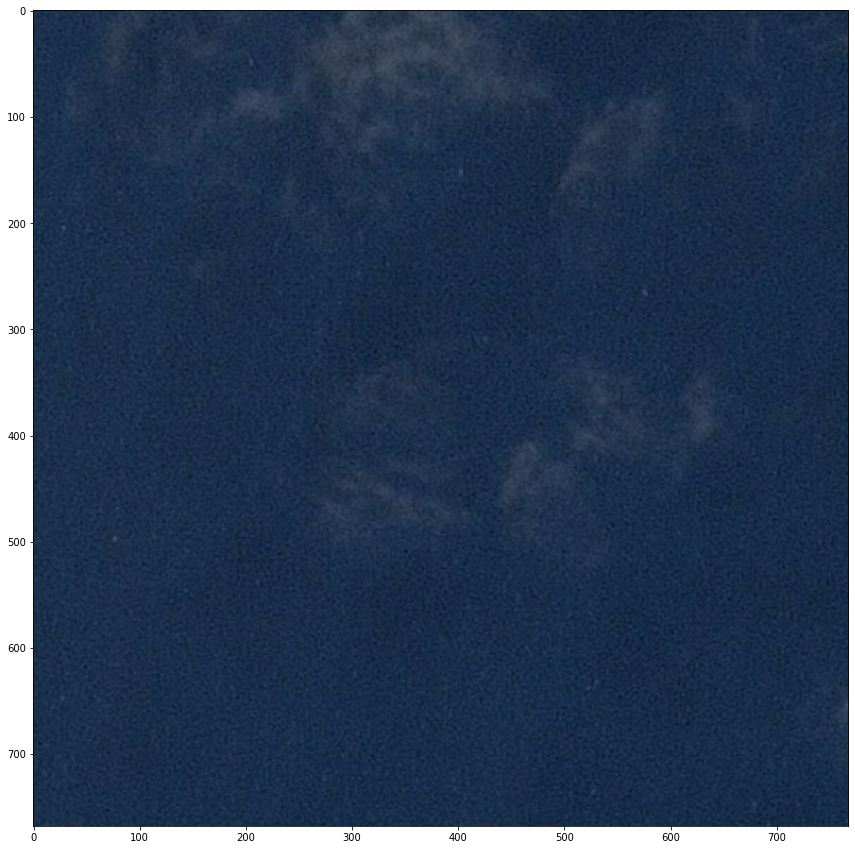

In [33]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.imshow(image)

In [34]:
train = pd.read_csv('Data/train_ship_segmentations_v2.csv')
# train.set_index('ImageId', inplace=True)
train.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [35]:
len(train)

231723

In [36]:
train.isna().sum()

ImageId               0
EncodedPixels    150000
dtype: int64

In [37]:
train.count()

ImageId          231723
EncodedPixels     81723
dtype: int64

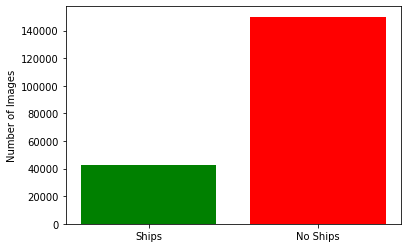

In [38]:
ships = train[~train.EncodedPixels.isna()].ImageId.unique()
noships = train[train.EncodedPixels.isna()].ImageId.unique()
plt.bar(['Ships', 'No Ships'], [len(ships), len(noships)], color=["green","red"]);
plt.ylabel('Number of Images');

In [39]:
len(train.ImageId.unique())

192556

In [40]:
len(train.ImageId)

231723

In [41]:
len(train.EncodedPixels.unique())

81723

In [42]:
len(train.EncodedPixels)

231723

In [43]:
train.ImageId[train.ImageId.duplicated(keep=False)]

3         000194a2d.jpg
4         000194a2d.jpg
5         000194a2d.jpg
6         000194a2d.jpg
7         000194a2d.jpg
              ...      
231669    ffef7c3f3.jpg
231670    ffef7c3f3.jpg
231671    ffef7c3f3.jpg
231712    fffd924fb.jpg
231713    fffd924fb.jpg
Name: ImageId, Length: 54619, dtype: object

In [44]:
len(train.ImageId[train.ImageId.duplicated(keep=False)].unique())

15452

In [45]:
train['ShipCount'] = train.groupby('ImageId')['ImageId'].transform('count')
train_no_duplicates = train.drop_duplicates(subset=['ImageId'])

In [46]:
train_no_duplicates = train_no_duplicates.sort_values('ShipCount', ascending=False)

(768, 768, 3)

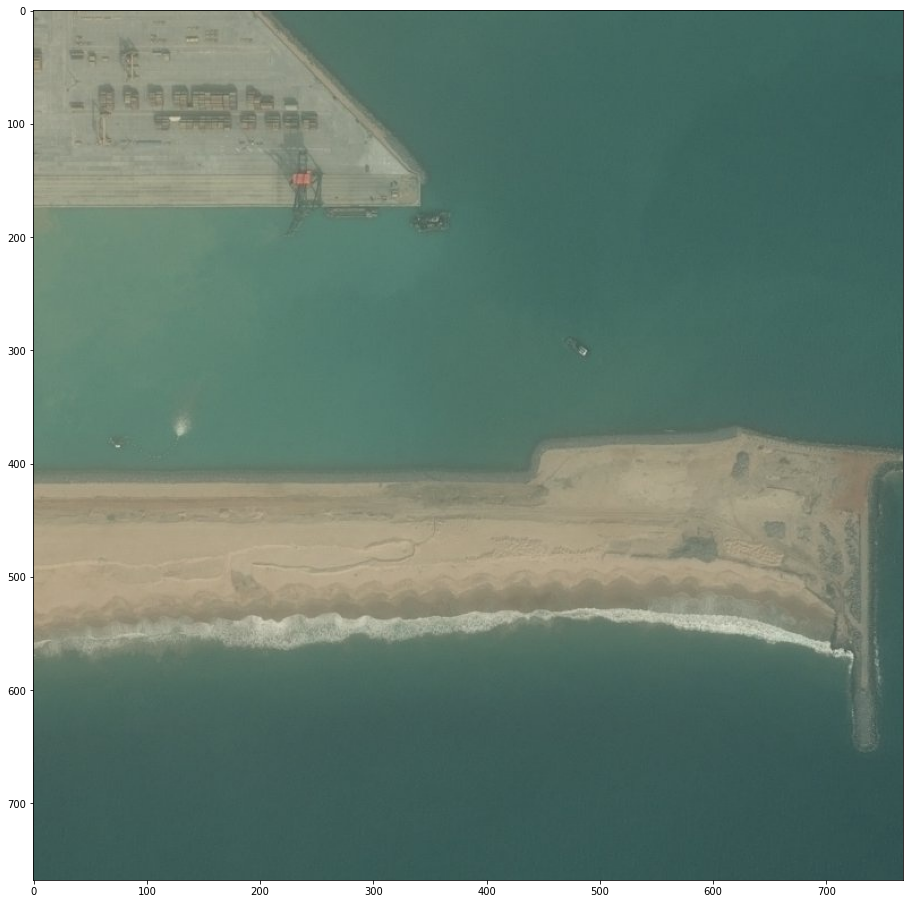

In [47]:
image = cv2.imread(glob.glob("Data/train_v2/000194a2d.jpg")[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 16))
plt.imshow(image)
image.shape

In [48]:
train_no_duplicates.head(5)

ImageId                                      EncodedPixels  \
208972  e6fd0c12e.jpg  535742 2 536508 4 537274 7 538040 9 538807 8 5...   
29048   2053a78bd.jpg  154445 2 155211 5 155978 6 156747 6 157515 6 1...   
191522  d3c47b3d3.jpg                         516824 2 517591 2 521428 1   
70322   4de149bd9.jpg  517904 1 518671 3 519438 5 520205 7 520972 9 5...   
181934  c8e722430.jpg  296277 4 297045 8 297813 7 298581 7 299349 7 3...   

        ShipCount  
208972         15  
29048          15  
191522         15  
70322          15  
181934         15

(array([    0., 27104.,  7674.,  2954.,  1622.,   925.,   657.,   406.,
          318.,   243.,   168.,   144.,   124.,   151.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 14 artists>)

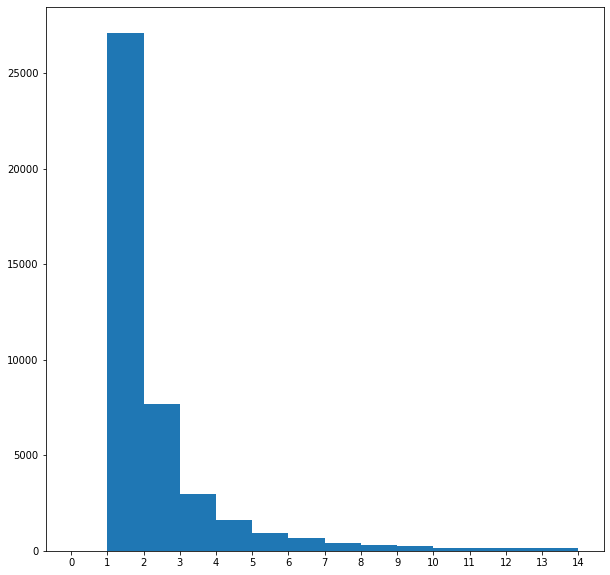

In [49]:
plt.figure(figsize=(10, 10))
plt.xticks(range(20))
plt.hist(train_no_duplicates.ShipCount[~train_no_duplicates.EncodedPixels.isna()], bins=range(15))

(768, 768, 3)

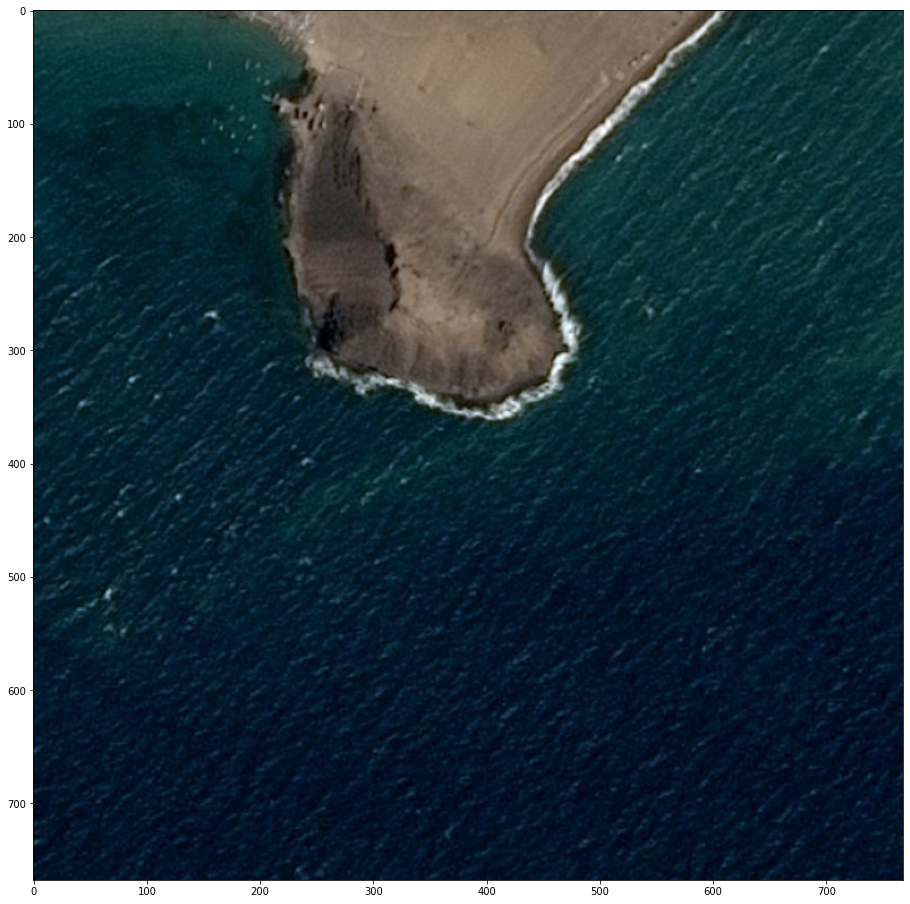

In [50]:
image = cv2.imread(glob.glob("Data/train_v2/2053a78bd.jpg")[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 16))
plt.imshow(image)
image.shape

(768, 768, 3)

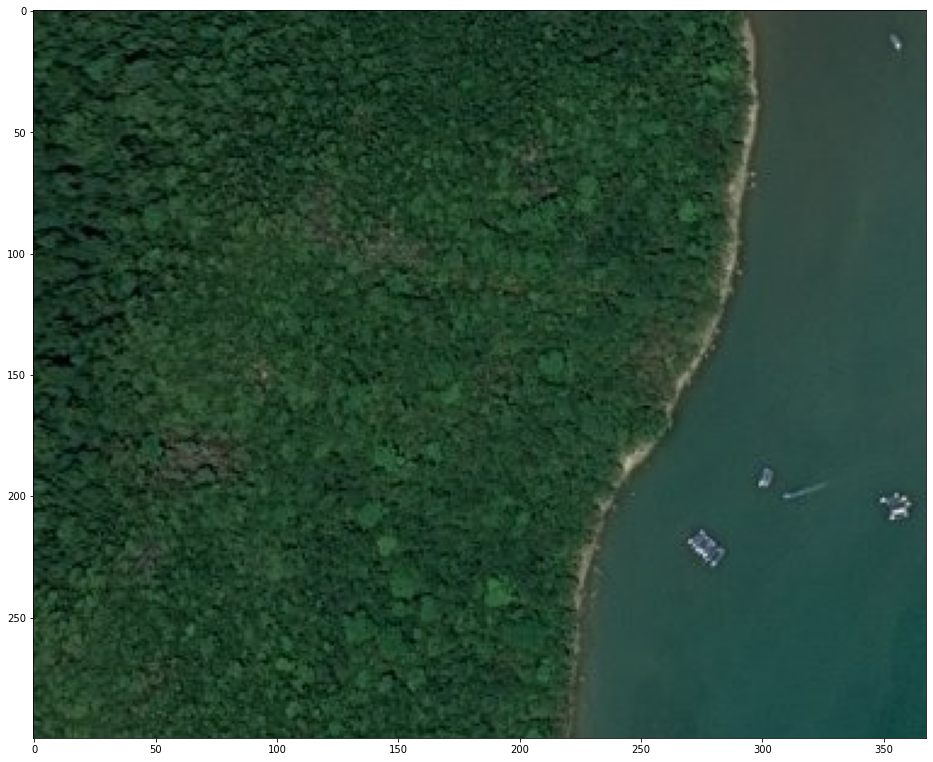

In [51]:
image = cv2.imread(glob.glob("Data/train_v2/e6fd0c12e.jpg")[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 16))
plt.imshow(image[250:550,400:,:])
image.shape

In [237]:
def get_mask(img_id, df):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    masks = df.loc[df['ImageId'] == img_id].EncodedPixels
    if(type(masks.iloc[0]) == float): 
        return img.reshape(shape)
    elif(type(masks) == str): 
        masks = [masks]
    for idx, mask in enumerate(masks):
        s = mask.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = (idx+1)*5
    return img.reshape(shape).T

In [72]:
def get_ship_size(px):
    shape = (768,768)
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = px.split()
    for i in range(len(s)//2):
        start = int(s[2*i]) - 1
        length = int(s[2*i+1])
        img[start:start+length] = 1
    return img.reshape(shape).T.sum()

In [96]:
def plot_ship_masks(sample_imgids):
    fig, ax = plt.subplots(2, 5, sharex='col', sharey='row')
    fig.set_size_inches(20, 10)
    fig.tight_layout()
    for i, imgid in enumerate(sample_imgids):
        col = i % 5
        row = i // 5
        
        if os.path.isfile("Data/train_v2/{}".format(imgid)):
            img = cv2.imread('Data/train_v2/{}'.format(imgid))
        elif os.path.isfile("Data/test_v2/{}".format(imgid)):
            img = cv2.imread('Data/test_v2/{}'.format(imgid))
        else:
            print("Lmao where is file {}!".format(imgid))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = get_mask(imgid, train)
        plot = ax[row, col]
        plot.set_title(imgid)
        plot.axis('off')
        plot.imshow(img)
        
        plot = ax[row+1, col]
        plot.axis('off')
        plot.imshow(mask)

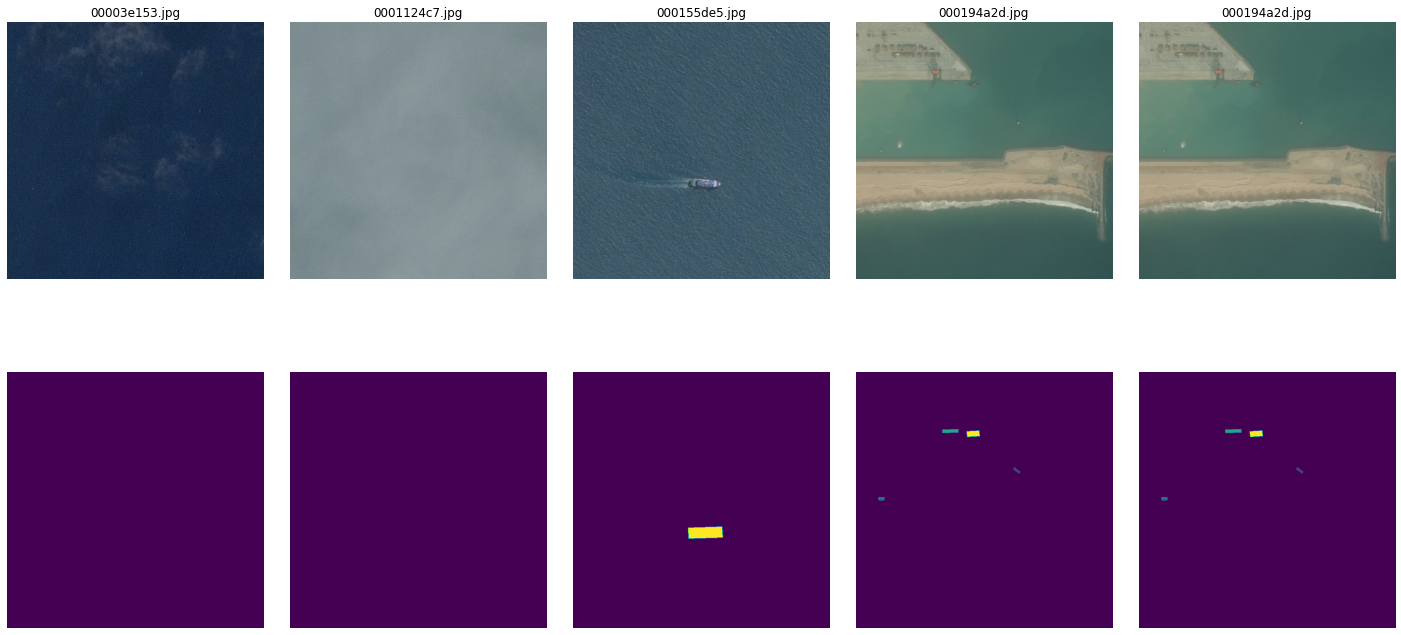

In [239]:
ship_count = train.groupby([train.index]).size()
sample_imgids = list(train[ship_count == 1].ImageId)[:5]
plot_ship_masks(sample_imgids)

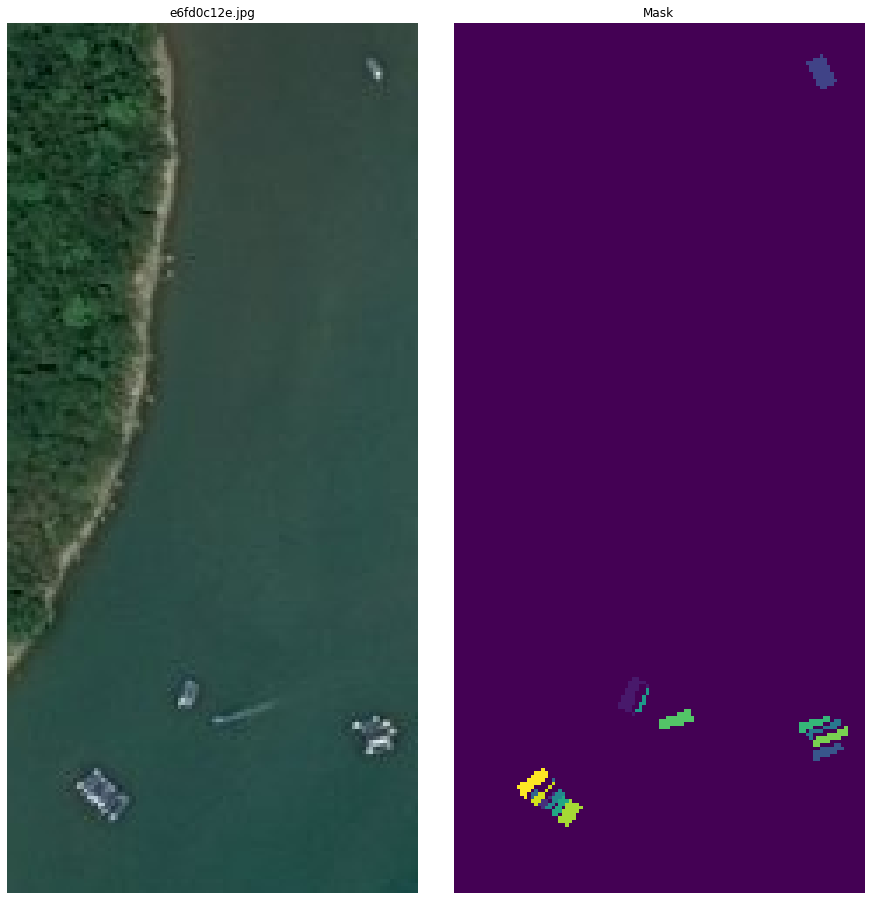

In [238]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 16)
fig.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

plot = ax[0]
plot.set_title("e6fd0c12e.jpg")
plot.axis('off')
img = cv2.imread(glob.glob("Data/train_v2/e6fd0c12e.jpg")[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot.imshow(img[250:500,650:,:])

plot = ax[1]
plot.set_title("Mask")
plot.axis('off')
mask = get_mask("e6fd0c12e.jpg", train)
plot.imshow(mask[250:500,650:])

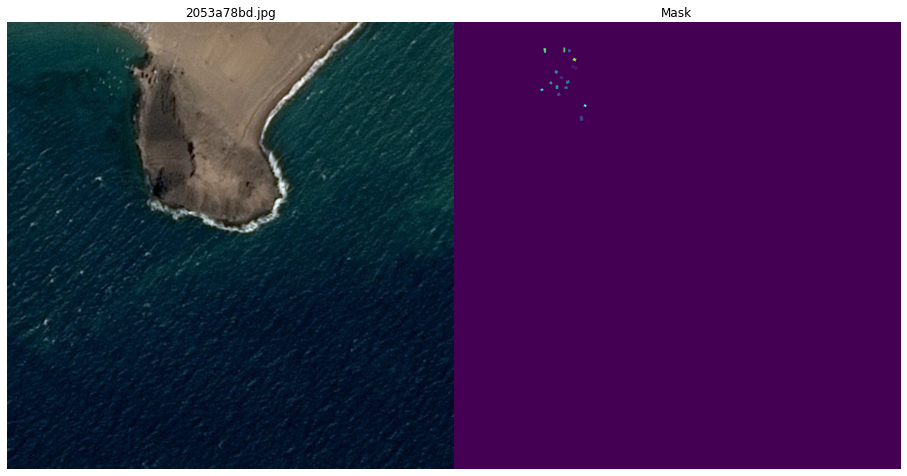

In [241]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 16)
fig.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

plot = ax[0]
plot.set_title("2053a78bd.jpg")
plot.axis('off')
img = cv2.imread(glob.glob("Data/train_v2/2053a78bd.jpg")[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot.imshow(img)

plot = ax[1]
plot.set_title("Mask")
plot.axis('off')
mask = get_mask("2053a78bd.jpg", train)
plot.imshow(mask)